# 【問題1】SVM分類器のクラスを作成する

scikit-learnの実装はソフトマージンSVMになっています。ハードマージンSVMを再現するには、パラメータCをC=1e10のように非常に大きな値を設定します。（無限大に向けてCを大きくするほどハードマージンSVMに近づきます）

また、線形カーネルをscikit-learnで使う場合はkernel="linear"と指定します。デフォルトではkernel="rbf"になっており、多項式カーネルと呼ばれるものになっています。

In [1]:
import numpy as np
import math
from sklearn.metrics import accuracy_score
import copy 
import time
import matplotlib.pyplot as plt
%matplotlib inline

class ScratchSVMClassifier():
    """
    SVM分類のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    threshold : float
      ラムダの閾値
    bias : bool
      バイアス項を入れる場合はTrue
    kernel : str
      カーネルの選択
      L ： ライナーカーネル
      pn : 多項式カーネル
    ganma: float
        多項式カーネルのパラメーター
    thetazero: float
        多項式カーネルのパラメーター
    d : float
        多項式カーネルのパラメーター
    
    Attributes
    ----------
    self.theta_ : 次の形のndarray, shape (n_features,1)
      パラメータ
    """

    def __init__(self, num_iter=10000, lr=0.00000001, threshold=0.1**5, bias=True, kernel="L", ganma=1, thetazero=0, d=1):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.lam = 0
        self.lam_X = 0
        self.lam_y = 0
        self.theta = 0
        self.threshold = threshold
        self.kernel = kernel
        
        #多項式カーネルのパラメーター３つ
        self.ganma = ganma 
        self.thetazero = thetazero
        self.d = d
    
    def fit(self, X, y):
        
        #時間の測定
        t0 = time.time()
        # バイアスの処理
        if self.bias:
            m = len(X)
            X = np.hstack((np.ones(m).reshape(m, 1), X))
            
        #ラベル０をマイナス１に変換
        y_train = copy.deepcopy(y)
        y_train[y_train==0] = -1
        #リシェイプ
        y_train = y_train.reshape(len(y), 1)
        #ラムダの更新
        self._compute_lambda(X, y_train)
        
        #時間の表示
        t1 = time.time()
        print('time : {}s'.format(t1-t0))
        
    def predict(self, X):
        # バイアスの処理
        if self.bias:
            m = len(X)
            X = np.hstack((np.ones(m).reshape(m, 1), X))
            
        if self.kernel == "L":
            pred = np.dot(self._linear_kernel(X, self.lam_X.T), self.lam * self.lam_y)
        if self.kernel == "pn":
            pred = np.dot(self._polynomial_kernel(X, self.lam_X.T), self.lam * self.lam_y)
        #pred = np.dot(X, self.theta)
        pred = (pred >= 0).astype(int)
        return pred
    
    def _compute_lambda(self, X, y):
        
        # lambdaの初期化
        lam = np.random.rand(len(X), 1)
        #lam = np.ones(len(X)).reshape(len(X), 1)
        #lam = np.zeros(len(X)).reshape(len(X), 1)
        lam = lam * 1e-7
        
        for _ in range(self.iter):
            #ライナーカーネル
            if self.kernel == "L":
                lam = lam + self.lr * (1 - np.dot(np.dot(y, y.T) * self._linear_kernel(X, X.T), lam))
            
            #多項式カーネル
            if self.kernel == "pn":
                lam = lam + self.lr * (1 - np.dot(np.dot(y, y.T) * self._polynomial_kernel(X, X.T), lam))
            
            #ゼロ以下のラムダをゼロに置き換える
            lam = np.where(lam < 0, 0, lam)  
            
            if sum((lam > self.threshold).astype(int)) >= 15:
                print("ラムダ更新回数")
                print(_)
                break
        
        #閾値以上のサポートベクトルを抜き出す
        self.lam = lam[np.any(lam > self.threshold, axis=1), :]
        self.lam_X = X[np.any(lam > self.threshold, axis=1), :]
        self.lam_y = y[np.any(lam > self.threshold, axis=1), :]
        #thetaの計算n*1のベクトル
        self.theta = np.dot(self.lam_X.T, self.lam * self.lam_y)
        if len(self.lam) == 0:
            print("エラー：サポートベクトルが見つかりません")
        
    def _linear_kernel(self, x1, x2):
        
        return np.dot(x1, x2)
    
    def _polynomial_kernel(self, x1, x2):
        
        return self.ganma * ((np.dot(x1, x2) + self.thetazero) ** self.d)
        
    def accuracy(self, y_test, y_pred):
        #accuracyを計算して返す
        return accuracy_score(y_test, y_pred)

In [2]:
#アイリスデータの取り込み
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names) #Dataframe ”X”を作成
#columns = ["petal length (cm)", "petal width (cm)"]
columns = ['sepal length (cm)', 'petal length (cm)']
X = X[columns]
X["TARGET"] = iris.target
X = X[X["TARGET"] > 0]
y = X["TARGET"].values
y[y==2] = 0
X = X.drop("TARGET", axis = 1).values

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [3]:
#シンプルデータセット１
import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0= [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

y = np.where(copy.deepcopy(y) == -1, 0, y)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [4]:
#シンプルデータセット２
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [5]:
model = ScratchSVMClassifier(lr=1e-8, kernel="L", ganma=1, d=1, num_iter=80000)
model.fit(X_train, y_train)

ラムダ更新回数
994
time : 0.09577798843383789s


In [6]:
model.lam.shape

(15, 1)

In [7]:
model.lam_X.shape

(15, 3)

In [8]:
y_pred = model.predict(X_test)

# 【問題2】（アドバンス課題）多項式カーネル関数の作成

In [2433]:
model = ScratchSVMClassifier(lr=1e-9, kernel="pn", ganma=1.5, d=7, thetazero=0, num_iter=10000)
model.fit(X_train, y_train)

ラムダ更新回数
9977
time : 2.5397238731384277s


In [2434]:
y_pred = model.predict(X_test)

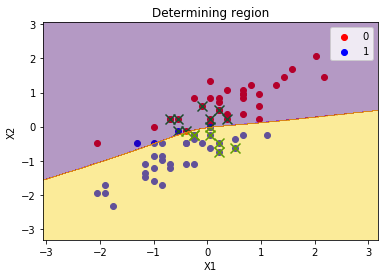

In [2437]:
#Xの散布図
X_train_label1 = X_train[y_train==0, :]
X_train_label2 = X_train[y_train==1, :]

plt.scatter(X_train_label1[:, 0], X_train_label1[:, 1],  c="red", edgecolor="red", label="0")
plt.scatter(X_train_label2[:, 0], X_train_label2[:, 1],  c="blue", edgecolor="blue", label="1")

#サポートベクトルの散布図
plt.scatter(model.lam_X[:,1], model.lam_X[:,2], marker="x", c="green", edgecolor="green", s=100)

#決定領域のプロット
xline = np.linspace(X_train[:, 0].min()-1,X_train[:, 1].max(),100) #X１の線
#budary = -(model.theta[0] + model.theta[1]  * xline) / model.theta[2]
budary = -(model.theta[1]  * xline) / model.theta[2]
#plt.plot(xline, budary)

#メッシュデータを作成
x1_min, x1_max = X_train[:, 0].min()-1, X_train[:, 0].max()+1
x2_min, x2_max = X_train[:, 1].min()-1, X_train[:, 1].max()+1
x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, 0.01),
                                   np.arange(x2_min, x2_max, 0.01))

#メッシュデータ全部を学習モデルで分類
z = model.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
z = z.reshape(x1_mesh.shape)
# メッシュデータと分離クラスを使って決定境界を描いている
plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, cmap="gnuplot")
plt.xlim(x1_mesh.min(), x1_mesh.max())
plt.ylim(x2_mesh.min(), x2_mesh.max())

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Determining region")
plt.legend()

# 【問題3】指標値の算出

In [9]:
#accuracyの算出
model.accuracy(y_test, y_pred)

0.4166666666666667

# 【問題4】決定領域の可視化
np.meshgrid https://deepage.net/features/numpy-meshgrid.html

np.ravel 一次元配列へ変換する https://deepage.net/features/numpy-ravel.html

plt.contourf 塗りつぶし。 https://matplotlib.org/api/_as_gen/matplotlib.pyplot.contourf.html

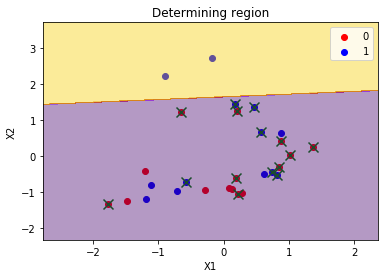

In [10]:
#Xの散布図
X_train_label1 = X_train[y_train==0, :]
X_train_label2 = X_train[y_train==1, :]

plt.scatter(X_train_label1[:, 0], X_train_label1[:, 1],  c="red", edgecolor="red", label="0")
plt.scatter(X_train_label2[:, 0], X_train_label2[:, 1],  c="blue", edgecolor="blue", label="1")

#サポートベクトルの散布図
plt.scatter(model.lam_X[:,1], model.lam_X[:,2], marker="x", c="green", edgecolor="green", s=100)

#決定領域のプロット
xline = np.linspace(X_train[:, 0].min()-1,X_train[:, 1].max(),100) #X１の線
#budary = -(model.theta[0] + model.theta[1]  * xline) / model.theta[2]
budary = -(model.theta[1]  * xline) / model.theta[2]
#plt.plot(xline, budary)

#メッシュデータを作成
x1_min, x1_max = X_train[:, 0].min()-1, X_train[:, 0].max()+1
x2_min, x2_max = X_train[:, 1].min()-1, X_train[:, 1].max()+1
x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, 0.01),
                                   np.arange(x2_min, x2_max, 0.01))

#メッシュデータ全部を学習モデルで分類
z = model.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
z = z.reshape(x1_mesh.shape)
# メッシュデータと分離クラスを使って決定境界を描いている
plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, cmap="gnuplot")
plt.xlim(x1_mesh.min(), x1_mesh.max())
plt.ylim(x2_mesh.min(), x2_mesh.max())

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Determining region")
plt.legend()

# 【問題6】ロジスティック回帰とSVM

- マージンを最大化するか、しないかが違う。
- ロジスティクス回帰は確率を出力するが、svmは決定領域を決めることで分類する。
- svmはカーネルを使うことで複雑な決定領域を求めることができる。
- svmは計算量が多い。学習ごとに、（行列X　＊　行列X　＊　ベクトルy　＊　ベクトルy　＊ ベクトルlamda）